### Contrastive Explanations on a public dataset
Quick test on the Boston housing dataset as it can be seen as a cold-start problem

In [29]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
from os import path as _p
from contrastiveRegressor import contrastiveRegressor

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import preprocessing_utils as pt
from generate_Gompertz_sales import generate_Gompertz_sales
import fcn_helpers as fhelp
import datetime as dt

In [30]:
# prepare some data
boston = load_boston()
y = boston.target
X = pd.DataFrame(boston.data, columns=boston.feature_names)
inputVars = X.columns.tolist()

In [31]:
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.25, random_state=42)

In [32]:
# Regressor
num_iterations = 600
learning_rate  = 0.15
depth = 12
num_neighbours = 5
validation_test_size = 0.20
feat_importance_keyword = 'feature_importances_'

In [33]:
# Create the forecaster
contrastiveReg = contrastiveRegressor(num_neighbours = num_neighbours, 
validation_test_size = validation_test_size)

# CatBoost
cb_model = CatBoostRegressor(iterations=num_iterations, learning_rate=learning_rate,
depth=depth, loss_function='RMSE', cat_features=None, silent=False)
# Set the regressor
contrastiveReg.set_regressor(cb_model, feat_importance_keyword, inputVars)
# fit the regressor
contrastiveReg.fit(X_train.values, y_train)
# eval results
contrastiveReg.predict_eval_test()
eval_results = contrastiveReg.get_results()

Preparing Training set...
Training set (1515, 26). Evaluation (380, 26)...done.
...Symmetrical Weights
MAE: 1.24
MSE: 2.60
RMSE: 1.61
meanError: -0.19
MAPE: 6.57
R2: 0.96
frc_error: 0.06
frc_bias: -0.01
frc_acc: 1.01
Var explained: 0.96


In [34]:
# Predict
contrastiveReg.predict(X_test.values)
cold_start_results = contrastiveReg.get_results()

...Symmetrical Weights


In [35]:
# Sort by importance
df_feature_importances = cold_start_results.get('df_feat_importances', None)
print(df_feature_importances)

                 0
RM       29.690510
LSTAT    26.417888
DIS       6.833884
TAX       5.295483
PTRATIO   5.158140
AGE       5.122108
B         4.654480
NOX       4.166632
RAD       3.910348
CRIM      3.808861
INDUS     2.896095
CHAS      1.110793
ZN        0.934777


In [36]:
_=contrastiveReg.get_frc_errors(y_test, cold_start_results['y_hat_weighted'])

MAE: 2.15
MSE: 11.23
RMSE: 3.35
meanError: 0.33
MAPE: 11.15
R2: 0.84
frc_error: 0.10
frc_bias: 0.02
frc_acc: 0.98
Var explained: 0.84


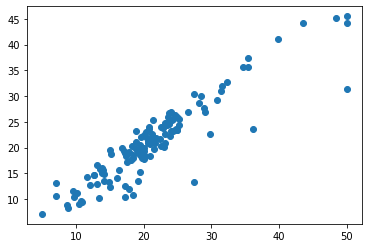

In [37]:
plt.scatter(y_test, cold_start_results['y_hat_weighted'])

In [38]:
# Predict with CatBoost (original)
y_hat_catboost = fhelp.frc_plain_CatBoost(num_neighbours, validation_test_size,
    num_iterations, learning_rate, depth, \
    contrastiveReg.X_train, contrastiveReg.y_train, X_test)


0:	learn: 9.0346178	test: 7.3716158	best: 7.3716158 (0)	total: 57.9ms	remaining: 34.7s
50:	learn: 1.1671842	test: 3.5294338	best: 3.5294338 (50)	total: 2.72s	remaining: 29.3s
100:	learn: 0.4113366	test: 3.4712149	best: 3.4691309 (96)	total: 5.67s	remaining: 28s
150:	learn: 0.1612490	test: 3.4714149	best: 3.4654375 (121)	total: 8.53s	remaining: 25.4s
200:	learn: 0.0801099	test: 3.4646410	best: 3.4644880 (194)	total: 11.1s	remaining: 22s
250:	learn: 0.0384823	test: 3.4625064	best: 3.4625064 (250)	total: 13.6s	remaining: 18.9s
300:	learn: 0.0200800	test: 3.4622858	best: 3.4622839 (298)	total: 16.1s	remaining: 16s
350:	learn: 0.0094904	test: 3.4621805	best: 3.4620751 (337)	total: 18.8s	remaining: 13.3s
400:	learn: 0.0046895	test: 3.4621816	best: 3.4620751 (337)	total: 21.6s	remaining: 10.7s
450:	learn: 0.0025483	test: 3.4621267	best: 3.4620751 (337)	total: 24.3s	remaining: 8.04s
500:	learn: 0.0012537	test: 3.4620951	best: 3.4620751 (337)	total: 27.2s	remaining: 5.37s
550:	learn: 0.0006522

In [39]:
# Predict with Extra Random Trees (sklearn)
y_hat_ERT = fhelp.frc_plain_extratrees(num_neighbours, depth, validation_test_size, 
                                            contrastiveReg.X_train, contrastiveReg.y_train, X_test.values)

In [40]:
# Predict with NGBoost
y_hat_NGBoost = fhelp.frc_plain_ngboost(num_iterations, learning_rate, validation_test_size, 
                                        contrastiveReg.X_train, contrastiveReg.y_train, 
                                        X_test.values)

[iter 0] loss=3.6408 val_loss=3.6381 scale=0.5000 norm=3.3848
[iter 100] loss=0.8581 val_loss=18.0923 scale=0.5000 norm=0.3715
[iter 200] loss=0.2529 val_loss=105.3759 scale=0.5000 norm=0.2569
[iter 300] loss=0.0477 val_loss=261.9135 scale=0.0005 norm=0.0002
[iter 400] loss=0.0430 val_loss=267.5069 scale=0.0010 norm=0.0005
[iter 500] loss=0.0255 val_loss=286.3627 scale=0.0010 norm=0.0005


In [41]:
# Arrange the results in a DF so we can easily plot them
df_test = X_test.copy()
df_test['y_actual'] = y_test
df_test['y_hat_catboost'] = y_hat_catboost
df_test['y_hat_extratrees'] = y_hat_ERT
df_test['y_hat_ngboost'] = y_hat_NGBoost
df_test['y_hat_contrastive'] = cold_start_results['y_hat_weighted']

#### Arrange the results per model

In [42]:
df_frc_metrics = []
for model_type in ['contrastive','catboost', 'extratrees', 'ngboost']:
    df_frc_metrics.append(pd.DataFrame([contrastiveReg.get_frc_errors(y_test, df_test['y_hat_' + model_type], False)], index=[model_type]))

df_frc_metrics = pd.concat(df_frc_metrics)
df_frc_metrics

,MAE,MSE,RMSE,meanError,MAPE,R2,frc_error,frc_bias,frc_acc,Var explained
contrastive,2.149956,11.225094,3.350387,0.325733,11.153019,0.839704,0.100402,0.015447,0.984553,0.841219
catboost,2.240338,12.004185,3.464706,0.476425,11.569335,0.828578,0.104623,0.022755,0.977245,0.831819
extratrees,2.308244,15.668235,3.958312,0.659751,11.171127,0.776255,0.107794,0.031790,0.968210,0.782471
ngboost,2.279355,13.496430,3.673749,0.353082,11.244633,0.807269,0.106445,0.016765,0.983235,0.809049
